# Take constrained output for WG3 and put into impulse response form

- Use constrained FaIR setup from 150 and 160
- apply Zeb's conversion
- test

In [1]:
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
from multiprocessing import Pool

from ar6.utils.h5 import *
from ar6.forcing.aerosol import aerocom_n, ghan
from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d

from tqdm.notebook import tqdm

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [2]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

## Climate model parameters

### load unconstrained

In [3]:
# ozone
ozone_feedback = np.load('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy')
beta_ch4 = np.load('../data_input_large/fair-samples/beta_ch4_unconstrained.npy')
beta_n2o = np.load('../data_input_large/fair-samples/beta_n2o_unconstrained.npy')
beta_ods = np.load('../data_input_large/fair-samples/beta_ods_unconstrained.npy')
beta_co = np.load('../data_input_large/fair-samples/beta_co_unconstrained.npy')
beta_voc = np.load('../data_input_large/fair-samples/beta_voc_unconstrained.npy')
beta_nox = np.load('../data_input_large/fair-samples/beta_nox_unconstrained.npy')

# carbon cycle
r0 = np.load('../data_input_large/fair-samples/r0_unconstrained.npy')
rC = np.load('../data_input_large/fair-samples/rC_unconstrained.npy')
rT = np.load('../data_input_large/fair-samples/rT_unconstrained.npy')
pre_ind_co2 = np.load('../data_input_large/fair-samples/pre_ind_co2_unconstrained.npy')

# aerosol
beta_so2 = np.load('../data_input_large/fair-samples/beta_so2_unconstrained.npy')
beta_bc = np.load('../data_input_large/fair-samples/beta_bc_unconstrained.npy')
beta_oc = np.load('../data_input_large/fair-samples/beta_oc_unconstrained.npy')
beta_nh3 = np.load('../data_input_large/fair-samples/beta_nh3_unconstrained.npy')
beta = np.load('../data_input_large/fair-samples/beta_unconstrained.npy')
aci_coeffs = np.load('../data_input_large/fair-samples/aci_coeffs.npy')

# forcing
scale_normals = np.load('../data_input_large/fair-samples/scale_normals.npy')
trend_solar = np.load('../data_input_large/fair-samples/scale_trend_solar.npy')

# climate response
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv', index_col=0)
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')
ecs = np.load('../data_input_large/fair-samples/ecs_unconstrained.npy')
tcr = np.load('../data_input_large/fair-samples/tcr_unconstrained.npy')

# accepted ensemble
accept_inds = np.loadtxt('../data_output_large/fair-samples/accept_inds.csv', dtype=int)

### apply the constraint and overwrite unconstrained

In [4]:
accept_inds

array([   156,    358,    441, ..., 998289, 998908, 999021])

In [5]:
geoff_sample_df.loc[accept_inds]

,q4x,lamg,cmix,cdeep,gamma_2l,eff
156,6.419499,-1.714643,8.810878,448.213437,0.440273,0.347264
358,8.646745,-1.817834,9.691545,103.494497,0.772469,1.585394
441,8.316302,-2.085561,5.696549,180.474488,0.821490,1.251474
636,7.889668,-0.796998,7.735094,89.445554,0.852359,1.535440
914,7.034846,-1.315331,8.992672,168.484833,0.709503,1.100228
...,...,...,...,...,...,...
996792,7.585270,-1.281183,8.745431,62.417455,0.755601,1.668154
996846,7.574501,-1.881943,9.089493,452.306881,0.565309,0.532951
998289,7.528928,-1.436389,7.878012,109.737561,0.522615,1.350649
998908,8.727801,-1.409111,9.221984,128.496448,0.521846,1.581632


In [6]:
# ozone
ozone_feedback = ozone_feedback[accept_inds]
beta_ch4 = beta_ch4[accept_inds]
beta_n2o = beta_n2o[accept_inds]
beta_ods = beta_ods[accept_inds]
beta_co = beta_co[accept_inds]
beta_voc = beta_voc[accept_inds]
beta_nox = beta_nox[accept_inds]

# carbon cycle
pre_ind_co2 = pre_ind_co2[accept_inds]
r0 = r0[accept_inds]
rC = rC[accept_inds]
rT = rT[accept_inds]

# aerosol
beta_so2 = beta_so2[accept_inds]
beta_bc = beta_bc[accept_inds]
beta_oc = beta_oc[accept_inds]
beta_nh3 = beta_nh3[accept_inds]
beta = beta[accept_inds]
aci_coeffs = aci_coeffs[accept_inds]

# forcing
scale_normals = scale_normals[accept_inds]
trend_solar = trend_solar[accept_inds]

# climate response
geoff_sample_df = geoff_sample_df.loc[accept_inds]
f2x = f2x[accept_inds]
ecs = ecs[accept_inds]
tcr = tcr[accept_inds]

In [7]:
with open('../data_input/tunings/cmip6_twolayer_tuning_params.json', 'r') as filehandle:
    cmip6_models = json.load(filehandle)

f2x_median = np.median(f2x)
ecs_median = np.median(ecs)
tcr_median = np.median(tcr)

cmix_mean = cmip6_models['cmix']['mean']['EBM-epsilon']
cdeep_mean = cmip6_models['cdeep']['mean']['EBM-epsilon']
eff_mean = cmip6_models['eff']['mean']['EBM-epsilon']

lamg_median = f2x_median/ecs_median
kappa_median = -(f2x_median/ecs_median - f2x_median/tcr_median)
gamma_2l_median = kappa_median/eff_mean

lamg = -geoff_sample_df['lamg'].values
eff = geoff_sample_df['eff'].values
gamma_2l = geoff_sample_df['gamma_2l'].values
cdeep = geoff_sample_df['cdeep'].values
cmix = geoff_sample_df['cmix'].values

(array([121., 574., 807., 474., 185.,  37.,  10.,  16.,  10.,   3.]),
 array([6.80758831e-04, 3.38060015e-01, 6.75439272e-01, 1.01281853e+00,
        1.35019778e+00, 1.68757704e+00, 2.02495630e+00, 2.36233555e+00,
        2.69971481e+00, 3.03709407e+00, 3.37447332e+00]),
 <a list of 10 Patch objects>)

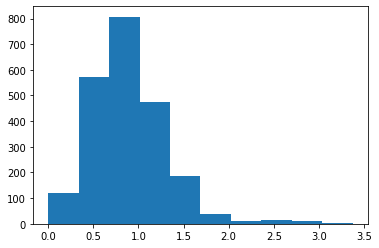

In [8]:
kappa = f2x/tcr - f2x/ecs
# kappa = efficacy * eta
pl.hist(kappa)

## Convert Geoffroy to impulse-response

- this is shamelessly copied from Zeb, but indpendence from pint and scmdata makes things run 10x faster
- TODO: move under `twolayermodel`

In [9]:
def _calculate_geoffroy_helper_parameters(
    cmix, cdeep, lambda0, efficacy, eta
):

    b_pt1 = (lambda0 + efficacy * eta) / cmix
    b_pt2 = eta / cdeep
    b = b_pt1 + b_pt2
    b_star = b_pt1 - b_pt2
    delta = b ** 2 - (4 * lambda0 * eta) / (cmix * cdeep)

    taucoeff = cmix * cdeep / (2 * lambda0 * eta)
    d1 = taucoeff * (b - delta ** 0.5)
    d2 = taucoeff * (b + delta ** 0.5)

    phicoeff = cmix / (2 * efficacy * eta)
    phi1 = phicoeff * (b_star - delta ** 0.5)
    phi2 = phicoeff * (b_star + delta ** 0.5)

    adenom = cmix * (phi2 - phi1)
    a1 = d1 * phi2 * lambda0 / adenom
    a2 = -d2 * phi1 * lambda0 / adenom

    qdenom = cmix * (phi2 - phi1)
    q1 = d1 * phi2 / qdenom
    q2 = -d2 * phi1 / qdenom

    out = {
        "d1": d1,
        "d2": d2,
        "q1": q1,
        "q2": q2,
        "efficacy": efficacy,
        "a1": a1,
        "a2": a2
    }
    return out

In [10]:
gh = _calculate_geoffroy_helper_parameters(
    cmix_mean, cdeep_mean, lamg_median, eff_mean, gamma_2l_median
)

In [11]:
gh

{'d1': 3.6302053280458884,
 'd2': 281.2825753992087,
 'q1': 0.4420035305477898,
 'q2': 0.2895034735678377,
 'efficacy': 1.3412508139190835,
 'a1': 0.6042369082742534,
 'a2': 0.3957630917257431}

In [12]:
bccesm11 = _calculate_geoffroy_helper_parameters(
    8.4, 56, 1.28, 1.27, 0.59, 
)

In [13]:
bccesm11

{'d1': 4.071963898885451,
 'd2': 152.9682903384027,
 'q1': 0.47664923825844835,
 'q2': 0.3046007617415519,
 'efficacy': 1.27,
 'a1': 0.6101110249708139,
 'a2': 0.3898889750291864}

## Get impulse response parameters for WG3 ensemble

In [14]:
output = []
a_out = []
for i in range(len(accept_inds)):
    gh = _calculate_geoffroy_helper_parameters(cmix[i], cdeep[i], lamg[i], eff[i], gamma_2l[i])
    output.append([accept_inds[i], cmix[i], cdeep[i], lamg[i], gamma_2l[i], kappa[i], gh['d1'], gh['d2'], gh['q1'], gh['q2'], eff[i], ecs[i], tcr[i], f2x[i]])
    a_out.append([gh['a1'], gh['a2']])
    
df = pd.DataFrame(output, columns=[
    'id',
    'C (W yr / m^2 / K)',
    'C_d (W yr / m^2 / K)',
    'alpha (W / m^2 / K)',
    'gamma (W / m^2 / K)',
    'kappa (W / m^2 / K)',
    'd1 (yr)',
    'd2 (yr)',
    'q1 (K / (W / m^2))',
    'q2 (K / (W / m^2))',
    'efficacy (dimensionless)',
    'ecs (K)',
    'tcr (K)',
    'erf2xCO2 (W / m^2)',
])

df_a = pd.DataFrame(a_out, columns=['a1', 'a2'])

In [15]:
df.median()

id                          476330.000000
C (W yr / m^2 / K)               8.323784
C_d (W yr / m^2 / K)           122.471519
alpha (W / m^2 / K)              1.367374
gamma (W / m^2 / K)              0.655173
kappa (W / m^2 / K)              0.843767
d1 (yr)                          3.696960
d2 (yr)                        314.073147
q1 (K / (W / m^2))               0.443775
q2 (K / (W / m^2))               0.283259
efficacy (dimensionless)         1.293304
ecs (K)                          2.953389
tcr (K)                          1.814646
erf2xCO2 (W / m^2)               4.037403
dtype: float64

In [16]:
q_df = df.quantile((0.50, 0.05, 0.95))

In [17]:
df.set_index('id', inplace=True)
df

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),gamma (W / m^2 / K),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),erf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
156,8.810878,448.213437,1.714643,0.440273,0.152891,4.716124,1109.234044,0.535057,0.048155,0.347264,2.115349,1.942170,3.627068
358,9.691545,103.494497,1.817834,0.772469,1.224668,3.154765,226.416477,0.322344,0.227762,1.585394,2.133679,1.274830,3.878673
441,5.696549,180.474488,2.085561,0.821490,1.028073,1.824505,328.895087,0.319394,0.160093,1.251474,1.800911,1.206278,3.755910
636,7.735094,89.445554,0.796998,0.852359,1.308746,3.594111,283.369438,0.454500,0.800208,1.535440,5.331884,2.018052,4.249502
914,8.992672,168.484833,1.315331,0.709503,0.780615,4.261504,380.975744,0.470647,0.289618,1.100228,2.902836,1.821702,3.818189
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996792,8.745431,62.417455,1.281183,0.755601,1.260458,3.369789,167.332810,0.377198,0.403331,1.668154,3.203013,1.614565,4.103645
996846,9.089493,452.306881,1.881943,0.565309,0.301282,4.160331,928.864999,0.457376,0.073989,0.532951,2.170608,1.871068,4.084962
998289,7.878012,109.737561,1.436389,0.522615,0.705869,3.656087,314.993589,0.461362,0.234828,1.350649,2.571759,1.724371,3.694047


In [18]:
q_df['id'] = ['median', '5th percentile', '95th percentile']
q_df.set_index('id', inplace=True)
q_df

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),gamma (W / m^2 / K),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),erf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
median,8.323784,122.471519,1.367374,0.655173,0.843767,3.696960,314.073147,0.443775,0.283259,1.293304,2.953389,1.814646,4.037403
5th percentile,6.030788,58.511844,0.803818,0.465854,0.327511,2.214454,147.403762,0.322272,0.099317,0.613726,2.054515,1.311732,3.563371
95th percentile,10.118715,258.464899,1.947091,0.893993,1.598579,5.649316,758.454277,0.611524,0.737910,2.000437,5.071012,2.569876,4.498439


In [19]:
full_df=q_df.append(df)
full_df

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),gamma (W / m^2 / K),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),erf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
median,8.323784,122.471519,1.367374,0.655173,0.843767,3.696960,314.073147,0.443775,0.283259,1.293304,2.953389,1.814646,4.037403
5th percentile,6.030788,58.511844,0.803818,0.465854,0.327511,2.214454,147.403762,0.322272,0.099317,0.613726,2.054515,1.311732,3.563371
95th percentile,10.118715,258.464899,1.947091,0.893993,1.598579,5.649316,758.454277,0.611524,0.737910,2.000437,5.071012,2.569876,4.498439
156,8.810878,448.213437,1.714643,0.440273,0.152891,4.716124,1109.234044,0.535057,0.048155,0.347264,2.115349,1.942170,3.627068
358,9.691545,103.494497,1.817834,0.772469,1.224668,3.154765,226.416477,0.322344,0.227762,1.585394,2.133679,1.274830,3.878673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996792,8.745431,62.417455,1.281183,0.755601,1.260458,3.369789,167.332810,0.377198,0.403331,1.668154,3.203013,1.614565,4.103645
996846,9.089493,452.306881,1.881943,0.565309,0.301282,4.160331,928.864999,0.457376,0.073989,0.532951,2.170608,1.871068,4.084962
998289,7.878012,109.737561,1.436389,0.522615,0.705869,3.656087,314.993589,0.461362,0.234828,1.350649,2.571759,1.724371,3.694047


In [20]:
full_df.to_csv('../data_output/impulse_response.csv')

In [22]:
df_a.mean()

a1    0.601912
a2    0.398088
dtype: float64